# Mauna Loa CO<sub>2</sub> Concentrations

Let's look at monthy-averaged CO<sub>2</sub> concentrations measured in Mauna Loa, Hawaii, using data hosted by the NOAA which can be downloaded with
```bash
!wget -q ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt -O ../data/co2_mm_mlo.txt
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!

import arviz as az

In [3]:
!head -60 ../data/co2_mm_mlo.txt | tail -n 10

# so that they are also indicated by negative numbers
#
# NOTE: Due to the eruption of the Mauna Loa Volcano, measurements from Mauna Loa Observatory
# were suspended as of Nov. 29, 2022. Observations starting in December 2022 are from a site
# at the Maunakea Observatories, approximately 21 miles north of the Mauna Loa Observatory.
# 
#            decimal       monthly    de-season  #days  st.dev  unc. of
#             date         average     alized          of days  mon mean
 1958    3   1958.2027      315.70      314.43     -1   -9.99   -0.99
 1958    4   1958.2877      317.45      315.16     -1   -9.99   -0.99


Let's skip the header, read in the data as an array, then extract the columns we're interested in.

In [4]:
data = np.genfromtxt('../data/co2_mm_mlo.txt', comments="#")
data

array([[ 1.9580000e+03,  3.0000000e+00,  1.9582027e+03, ...,
        -1.0000000e+00, -9.9900000e+00, -9.9000000e-01],
       [ 1.9580000e+03,  4.0000000e+00,  1.9582877e+03, ...,
        -1.0000000e+00, -9.9900000e+00, -9.9000000e-01],
       [ 1.9580000e+03,  5.0000000e+00,  1.9583699e+03, ...,
        -1.0000000e+00, -9.9900000e+00, -9.9000000e-01],
       ...,
       [ 2.0230000e+03,  1.0000000e+00,  2.0230417e+03, ...,
         3.1000000e+01,  4.0000000e-01,  1.4000000e-01],
       [ 2.0230000e+03,  2.0000000e+00,  2.0231250e+03, ...,
         2.5000000e+01,  6.2000000e-01,  2.4000000e-01],
       [ 2.0230000e+03,  3.0000000e+00,  2.0232083e+03, ...,
         3.1000000e+01,  7.4000000e-01,  2.5000000e-01]])

In [5]:
date = data[:, 2]
co2 = data[:, 3]
uncert = data[:, -1]
missing_uncert = uncert == -0.99  # track the missing measurement uncertainties

There is quantified uncertainty associated with the measurements, but not for the earliest data.  For now let's just model the scatter about our model as normal and infer the standard deviation.

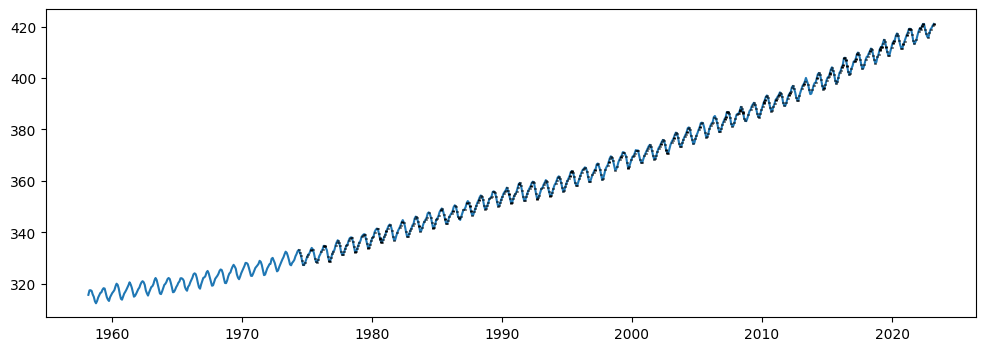

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(date, co2)
plt.errorbar(date[~missing_uncert], co2[~missing_uncert], yerr=uncert[~missing_uncert], lw=0, elinewidth=2, color='k');

To simplify things let's look at behavior relative to the first measurement.

In [7]:
date = data[:, 2]
date_offset = date[0]
date -= date_offset

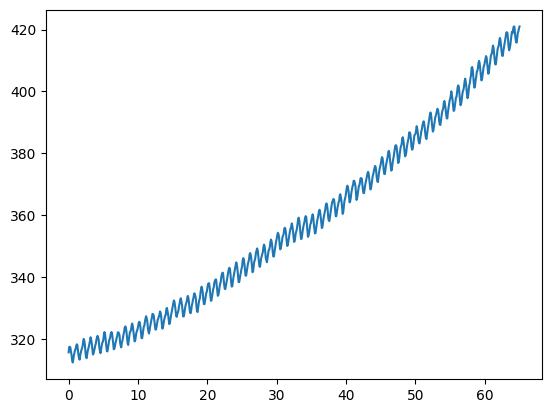

In [8]:
plt.plot(date, co2);

# Linear model

Let's start simple and model the data as a linear process.  This is going to look a lot like our previous attempts at linear regression with `NumPyro`.

In [9]:
def linear_model(time=None, co2=None):
    # priors
    m = numpyro.sample('m', dist.Normal(scale=10))
    b = numpyro.sample('b', dist.Normal(loc=300, scale=100))
    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ", m * time + b)

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("data", len(time)):
        obs = numpyro.sample('co2', dist.Normal(loc=μ, scale=σ), obs=co2)

In [10]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         time=date,
         co2=co2)
mcmc.print_summary()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b    305.37      0.34    305.37    304.79    305.91    910.86      1.00
         m      1.62      0.01      1.62      1.60      1.63    902.93      1.00
   scatter      4.72      0.12      4.72      4.52      4.90   1029.65      1.00

Number of divergences: 0


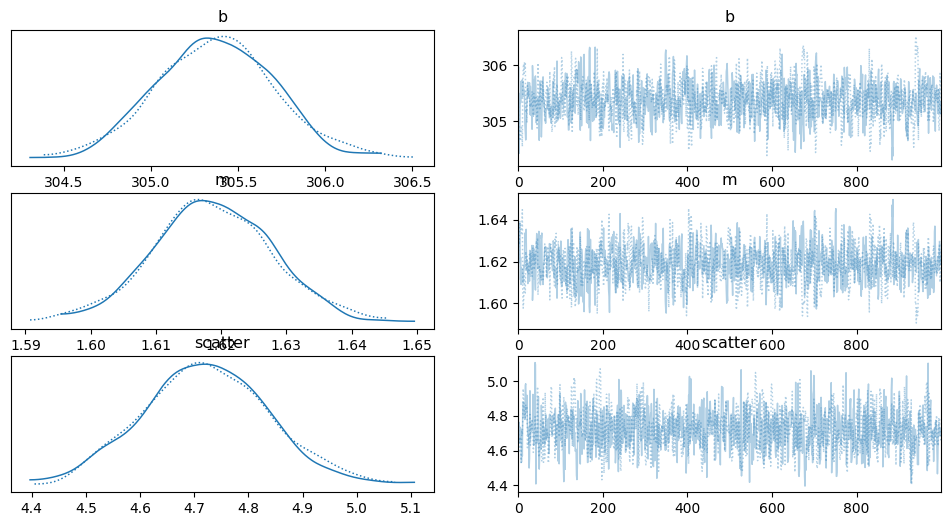

In [11]:
az.plot_trace(mcmc, var_names=["~μ"]);

Now let's use `NumPyro`'s posterior predictive framework to make predictions for observations based on our model and posterior estimate.

In [12]:
samples = mcmc.get_samples()

In [13]:
tgrid = np.linspace(date.min(), date.max(), 20)

post_pred_samples = infer.Predictive(linear_model, samples)(
    random.PRNGKey(1), time=tgrid,
)
post_pred_y = post_pred_samples["co2"]
post_pred_y.shape

(2000, 20)

In [14]:
post_pred_samples

{'co2': Array([[306.62134, 313.382  , 324.72516, ..., 395.11975, 396.21173,
         409.2326 ],
        [302.394  , 313.16437, 308.60162, ..., 406.07114, 407.07236,
         413.3595 ],
        [302.33884, 317.7218 , 324.83447, ..., 403.03268, 410.88748,
         409.02518],
        ...,
        [309.01938, 304.79898, 321.8659 , ..., 408.8154 , 405.64438,
         407.48462],
        [311.68115, 310.5965 , 319.31024, ..., 399.89386, 406.18896,
         404.492  ],
        [314.30344, 321.62305, 325.4609 , ..., 404.83875, 402.70197,
         414.6658 ]], dtype=float32),
 'μ': Array([[305.50107, 311.046  , 316.59094, ..., 399.76498, 405.30994,
         410.85486],
        [305.9672 , 311.48007, 316.99292, ..., 399.6859 , 405.19876,
         410.71164],
        [304.42084, 310.0037 , 315.58655, ..., 399.32925, 404.9121 ,
         410.49496],
        ...,
        [305.85208, 311.36078, 316.86945, ..., 399.49973, 405.0084 ,
         410.5171 ],
        [305.69022, 311.20944, 316.7287 , ...

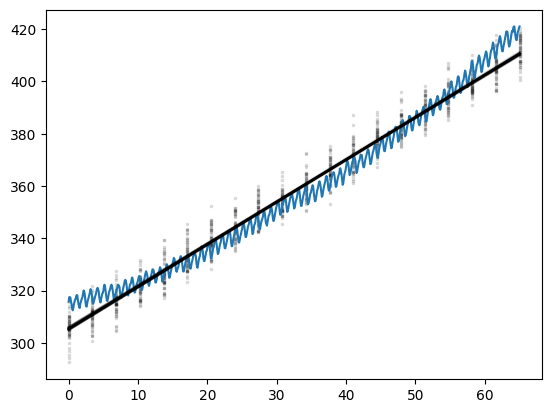

In [15]:
plt.plot(date, co2);
for i in random.choice(rng_key, len(post_pred_y), (50,)):
    plt.plot(tgrid, post_pred_samples['μ'][i], color='k', alpha=0.1)
    plt.scatter(tgrid, post_pred_y[i], color='k', marker=',', s=1, alpha=.1)

# Quadratic

We clearly have a long way to go.  The next thing we'll address are the general non-linear trends in the data; we'll leave the periodicity for last.  We'll take a baby step and move to the next polynomial order and try something quadratic.  I have no idea what to expect for coefficients, so let's start with 0-mean, broad Gaussians to start (σ=100), and we'll keep an eye on our posterior estimates to make sure we don't end up in the tails of such a distribution.

In [16]:
def quad_model(time=None, co2=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=100))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*time**2 + b*time + c) #this line is defining a quadratic with our priors for the coeffs

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("data", len(time)):
        obs = numpyro.sample('co2', dist.Normal(loc=μ, scale=σ), obs=co2)

In [17]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(quad_model)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         time=date,
         co2=co2)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.00      0.01      0.01      0.01    591.04      1.00
         b      0.76      0.02      0.76      0.74      0.80    507.81      1.00
         c    314.60      0.25    314.60    314.17    314.99    467.55      1.00
   scatter      2.23      0.06      2.23      2.14      2.32    622.80      1.00

Number of divergences: 0


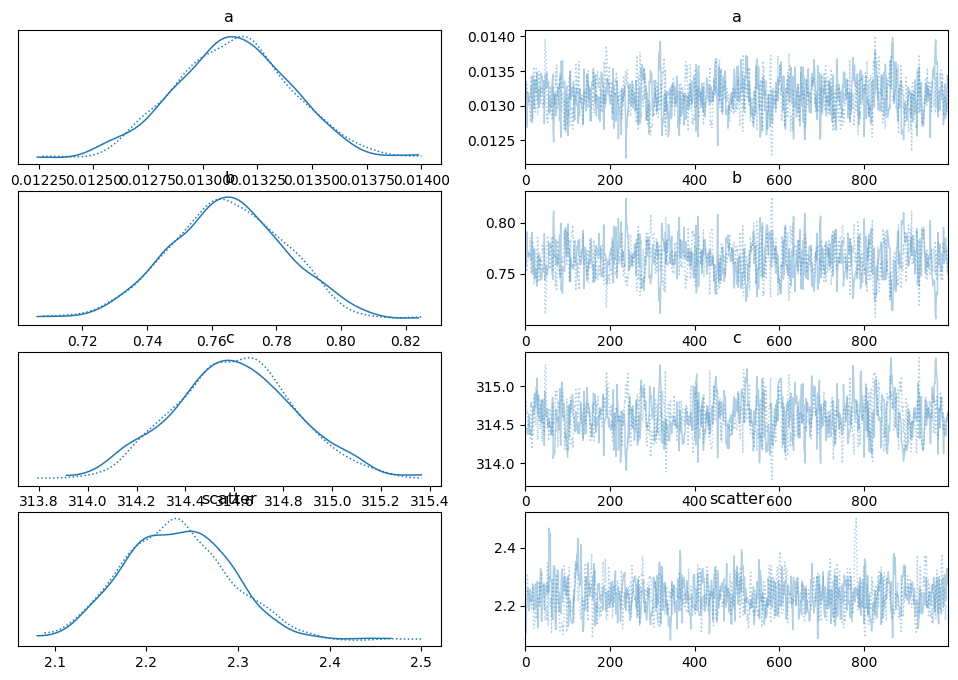

In [18]:
az.plot_trace(mcmc, var_names=["~μ"]);

It looks like $c$ wants to go big (not surprising since the CO<sub>2</sub> concentration is ~300 at $t=0$), so let's increase the prior width and run another MCMC.

In [19]:
def quad_model(time=None, co2=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=1000))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*time**2 + b*time + c) #It's the same thing!

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("data", len(time)):
        obs = numpyro.sample('co2', dist.Normal(loc=μ, scale=σ), obs=co2)

In [20]:
kernel = infer.NUTS(quad_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         time=date,
         co2=co2)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.00      0.01      0.01      0.01   2968.57      1.00
         b      0.76      0.02      0.76      0.74      0.79   2668.04      1.00
         c    314.61      0.24    314.61    314.23    315.02   2639.12      1.00
   scatter      2.23      0.06      2.23      2.14      2.32   3419.34      1.00

Number of divergences: 0


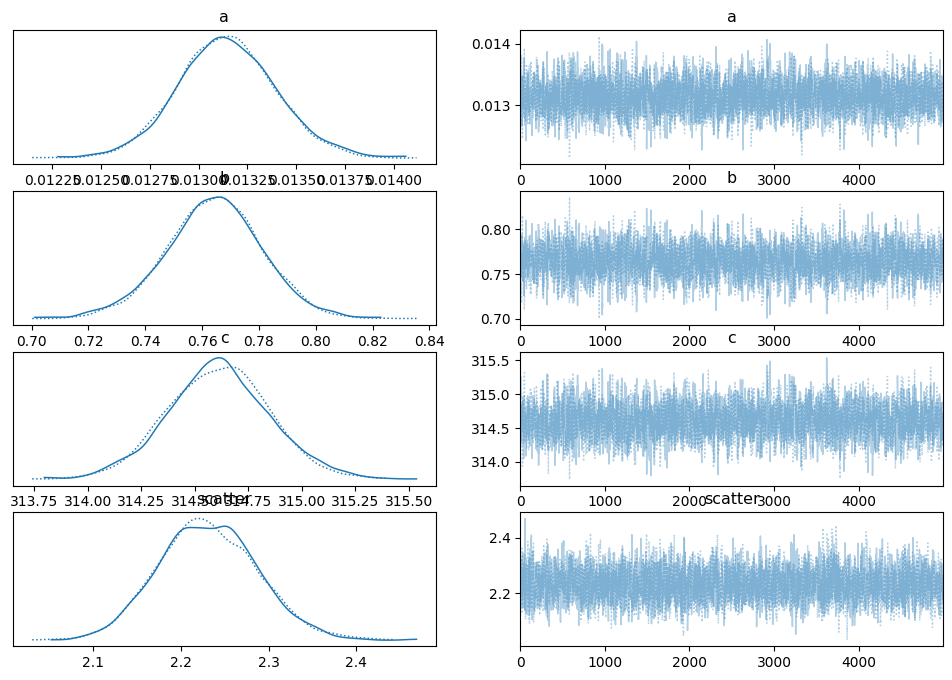

In [21]:
az.plot_trace(mcmc, var_names=["~μ"]);

Let's pick a bunch of random samples from random chains and plot the line the correspond to, to get a sense of the fit and uncertainties.

In [22]:
samples = mcmc.get_samples()

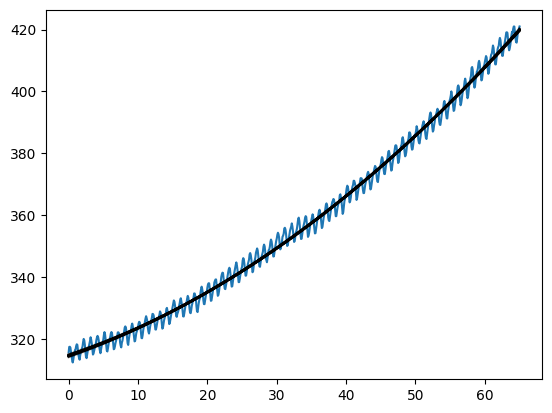

In [23]:
plt.plot(date, co2)

n_pos_draws = 100
for i in random.choice(rng_key, num_samples, shape=(n_pos_draws,)):
    plt.plot(date, samples['μ'][i], color='k', alpha=0.1)

Not bad.  Let's get a better look at our fit by looking at the residuals (data after subtracting the model).

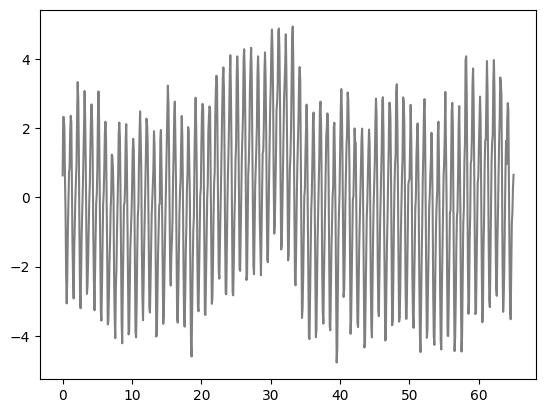

In [24]:
i = random.choice(rng_key, num_samples)
residuals = co2 - samples['μ'][i]
plt.plot(date, residuals, color='k', alpha=0.5);

# Let's go seasonal

There seems to be some clearly periodic fluctuations that are currently being absorbed by the random "noise" component of our model (the normal scatter about our quadratic function).

To explore this, let's try modeling the residuals using a periodic function.

In [25]:
def seasonal_model(time=None, residual_co2=None):
    # priors
    A = numpyro.sample('A', dist.HalfNormal(scale=10))
    f = numpyro.sample('f', dist.Normal(loc=1, scale=0.01))
    phi = numpyro.sample('φ', dist.Uniform(-jnp.pi, jnp.pi))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=0.1))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  A*jnp.sin(2*jnp.pi*f*time + phi)) # ah look! A sine function. Because temperate trees!

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("data", len(time)):
        obs = numpyro.sample('co2', dist.Normal(loc=μ, scale=σ), obs=residual_co2)

In [26]:
kernel = infer.NUTS(seasonal_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         time=date,
         residual_co2=residuals)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      2.83      0.05      2.83      2.75      2.90   4437.82      1.00
         f      1.00      0.00      1.00      1.00      1.00   6409.55      1.00
   scatter      0.94      0.02      0.94      0.90      0.97   4269.97      1.00
         φ      0.82      0.03      0.82      0.77      0.88   5501.14      1.00

Number of divergences: 0


In [27]:
samples = mcmc.get_samples()

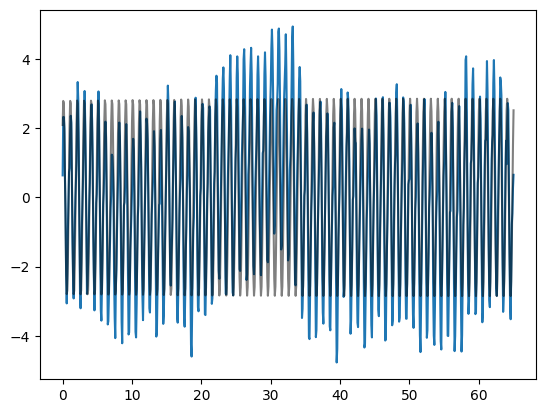

In [28]:
plt.plot(date, residuals)

plt.plot(date, samples['μ'][-1], color='k', alpha=0.5);

It's certainly not perfect, but it looks like the residuals have a periodic component with a frequency of ~1/year.  Let's get a sense of the uncertainties.

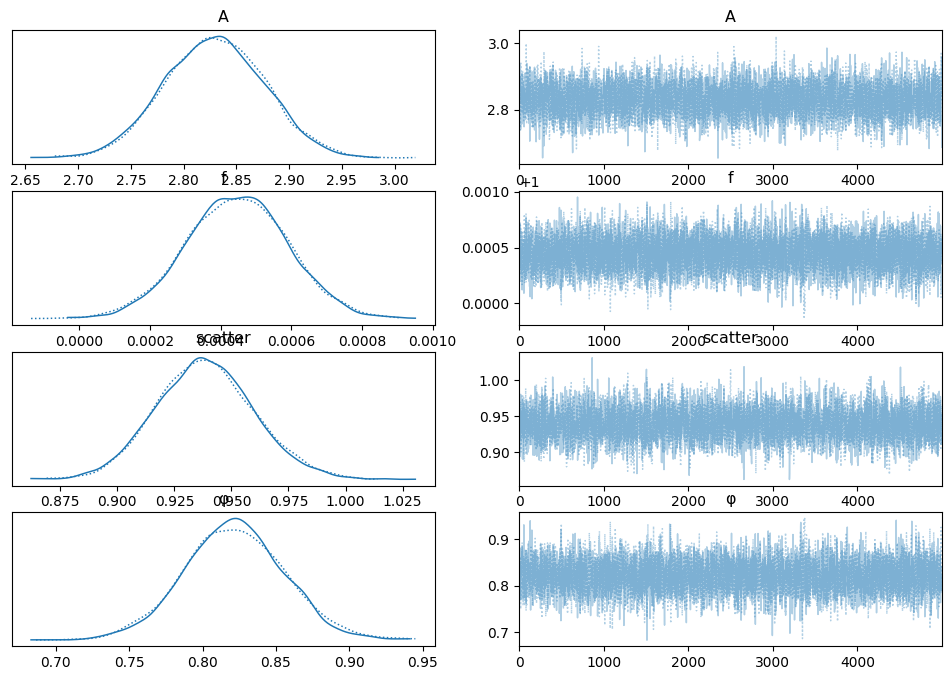

In [29]:
az.plot_trace(mcmc, var_names=['~μ']);

Let's look at the correlations.

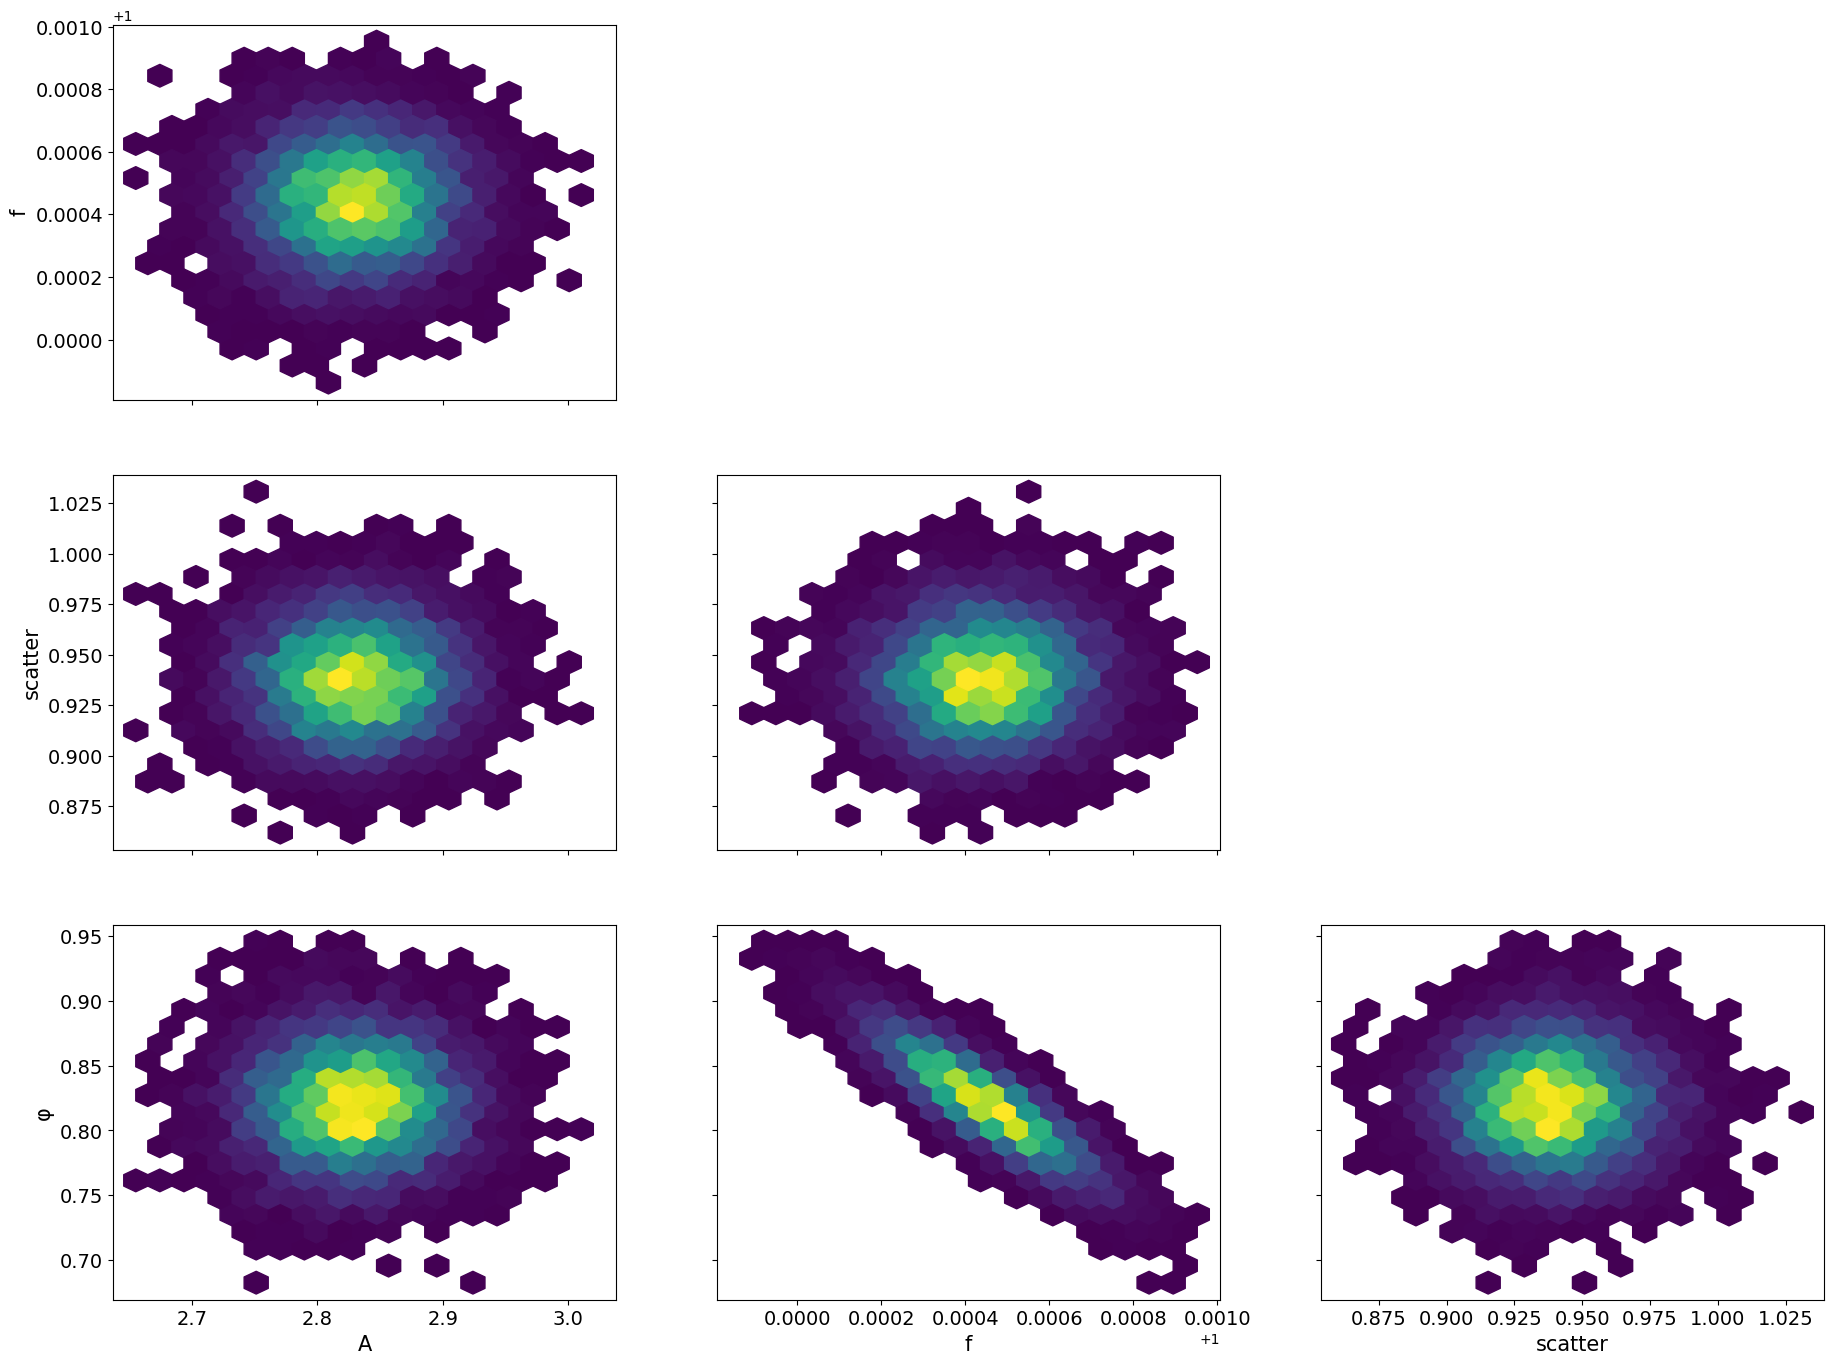

In [30]:
az.plot_pair(mcmc, var_names=['~μ'],kind='hexbin'); # also try adding kind='kde' or kind='hexbin'

Nice.  Now we (try to) address the fact that we performed an _iterative_ fit, i.e., we took a single (random) draw from our posterior distribution over quadratic coefficients, subtracted that model from the data, then sampled the posterior distribution over parameters of the periodic model.  By fixing the quadratic parameters we can't account for possible degeneracies between them with the parameters of our periodic component.

In [31]:
def quad_seasonal_model(time=None, co2=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=10))
    b = numpyro.sample('b', dist.Normal(scale=10))
    c = numpyro.sample('c', dist.Normal(scale=500))

    # priors
    A = numpyro.sample('A', dist.HalfNormal(scale=5))
    f = numpyro.sample('f', dist.Normal(loc=1, scale=0.1))
    phi = numpyro.sample('φ', dist.Uniform(-jnp.pi, jnp.pi))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=0.1))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*time**2 + b*time + c + A*jnp.sin(2*jnp.pi*f*time + phi))

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("data", len(time)):
        obs = numpyro.sample('co2', dist.Normal(loc=μ, scale=σ), obs=co2)

The posterior function here turns out to be _highly_ multi-modal, and chains are super prone to getting stuck in local maxima, especially in frequency.  Constraining this with the prior is the _wrong_ thing to do, if it means using your by-eye judgements of the periodicity of the data to force the MCMC to focus on a particular mode.  The prior is supposed to be data-agnostic, and doing this double counts the same information from your observations.  We may consider switching to a sampler better suited to multimodal distributions, and we should if there's a chance that the other modes in our posterior are actually significant, in which case we need our chain to move between them.  In this case the $f=1$ mode is _far_ higher in likelihood, to the point where we shouldn't expect the chain to visit the other modes.  So we can get away with starting our chain somewhere in this mode (which we have a good guess of from our previous fits) using the `init_to_value()` initialization strategy when constructing our kernel.

In [32]:
kernel = infer.NUTS(
    quad_seasonal_model,
    init_strategy=infer.init_to_value(values={'A':2.8, 'f': 1.0, 'scatter':0.9, 'φ':0.9}),
)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=2000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         time=date,
         co2=co2)
mcmc.print_summary()

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      2.83      0.05      2.83      2.76      2.91   6580.94      1.00
         a      0.01      0.00      0.01      0.01      0.01   5234.60      1.00
         b      0.77      0.01      0.77      0.76      0.78   4756.04      1.00
         c    314.55      0.10    314.55    314.40    314.72   4630.64      1.00
         f      1.00      0.00      1.00      1.00      1.00   7189.07      1.00
   scatter      0.92      0.02      0.92      0.88      0.95   6758.05      1.00
         φ      0.82      0.03      0.82      0.76      0.87   6411.27      1.00

Number of divergences: 0


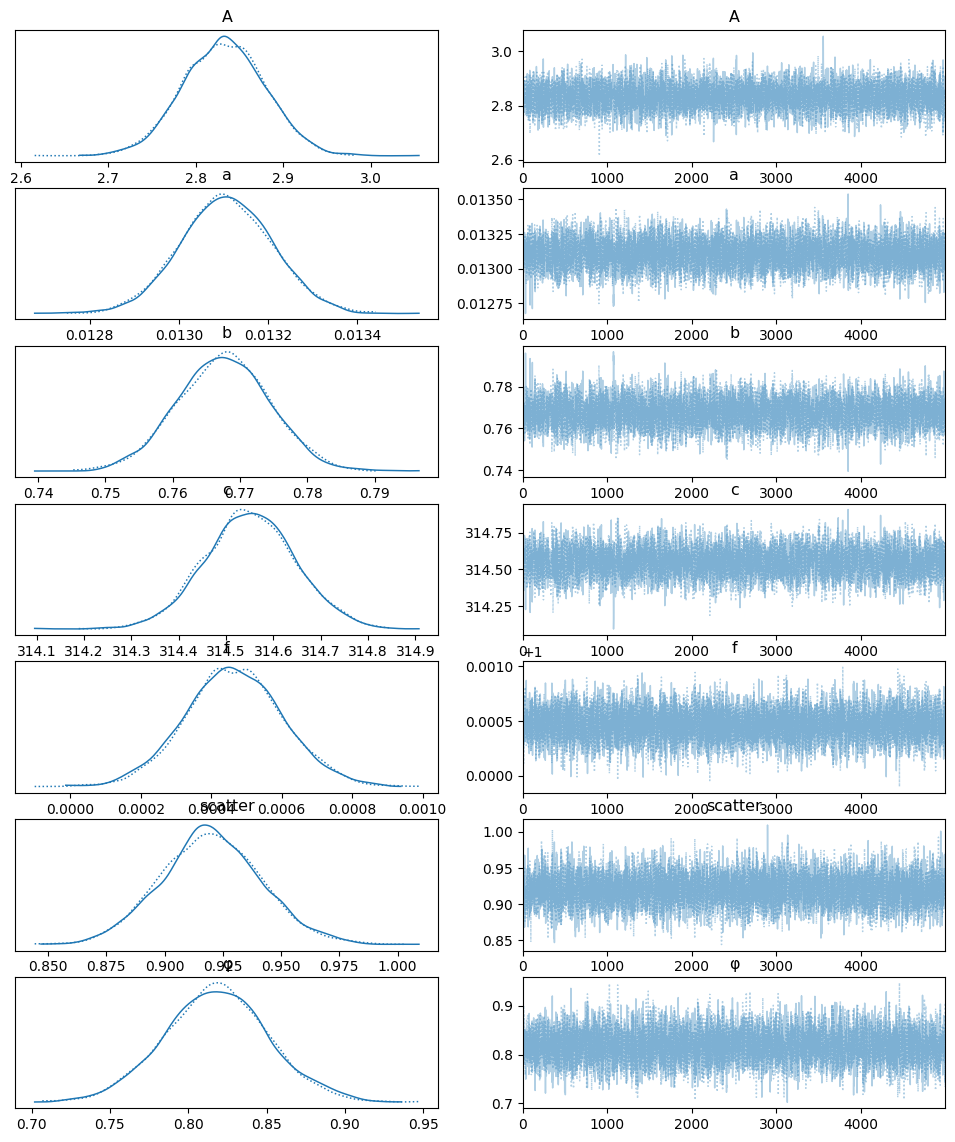

In [33]:
az.plot_trace(mcmc, var_names=['~μ']);

This looks great!  I encourage you to remove the initialization strategy above and see what a train wreck that can happen when starting the chains at random locations in parameter space.

Let's use a pair (i.e., corner) plot to look for correlations between parameters.

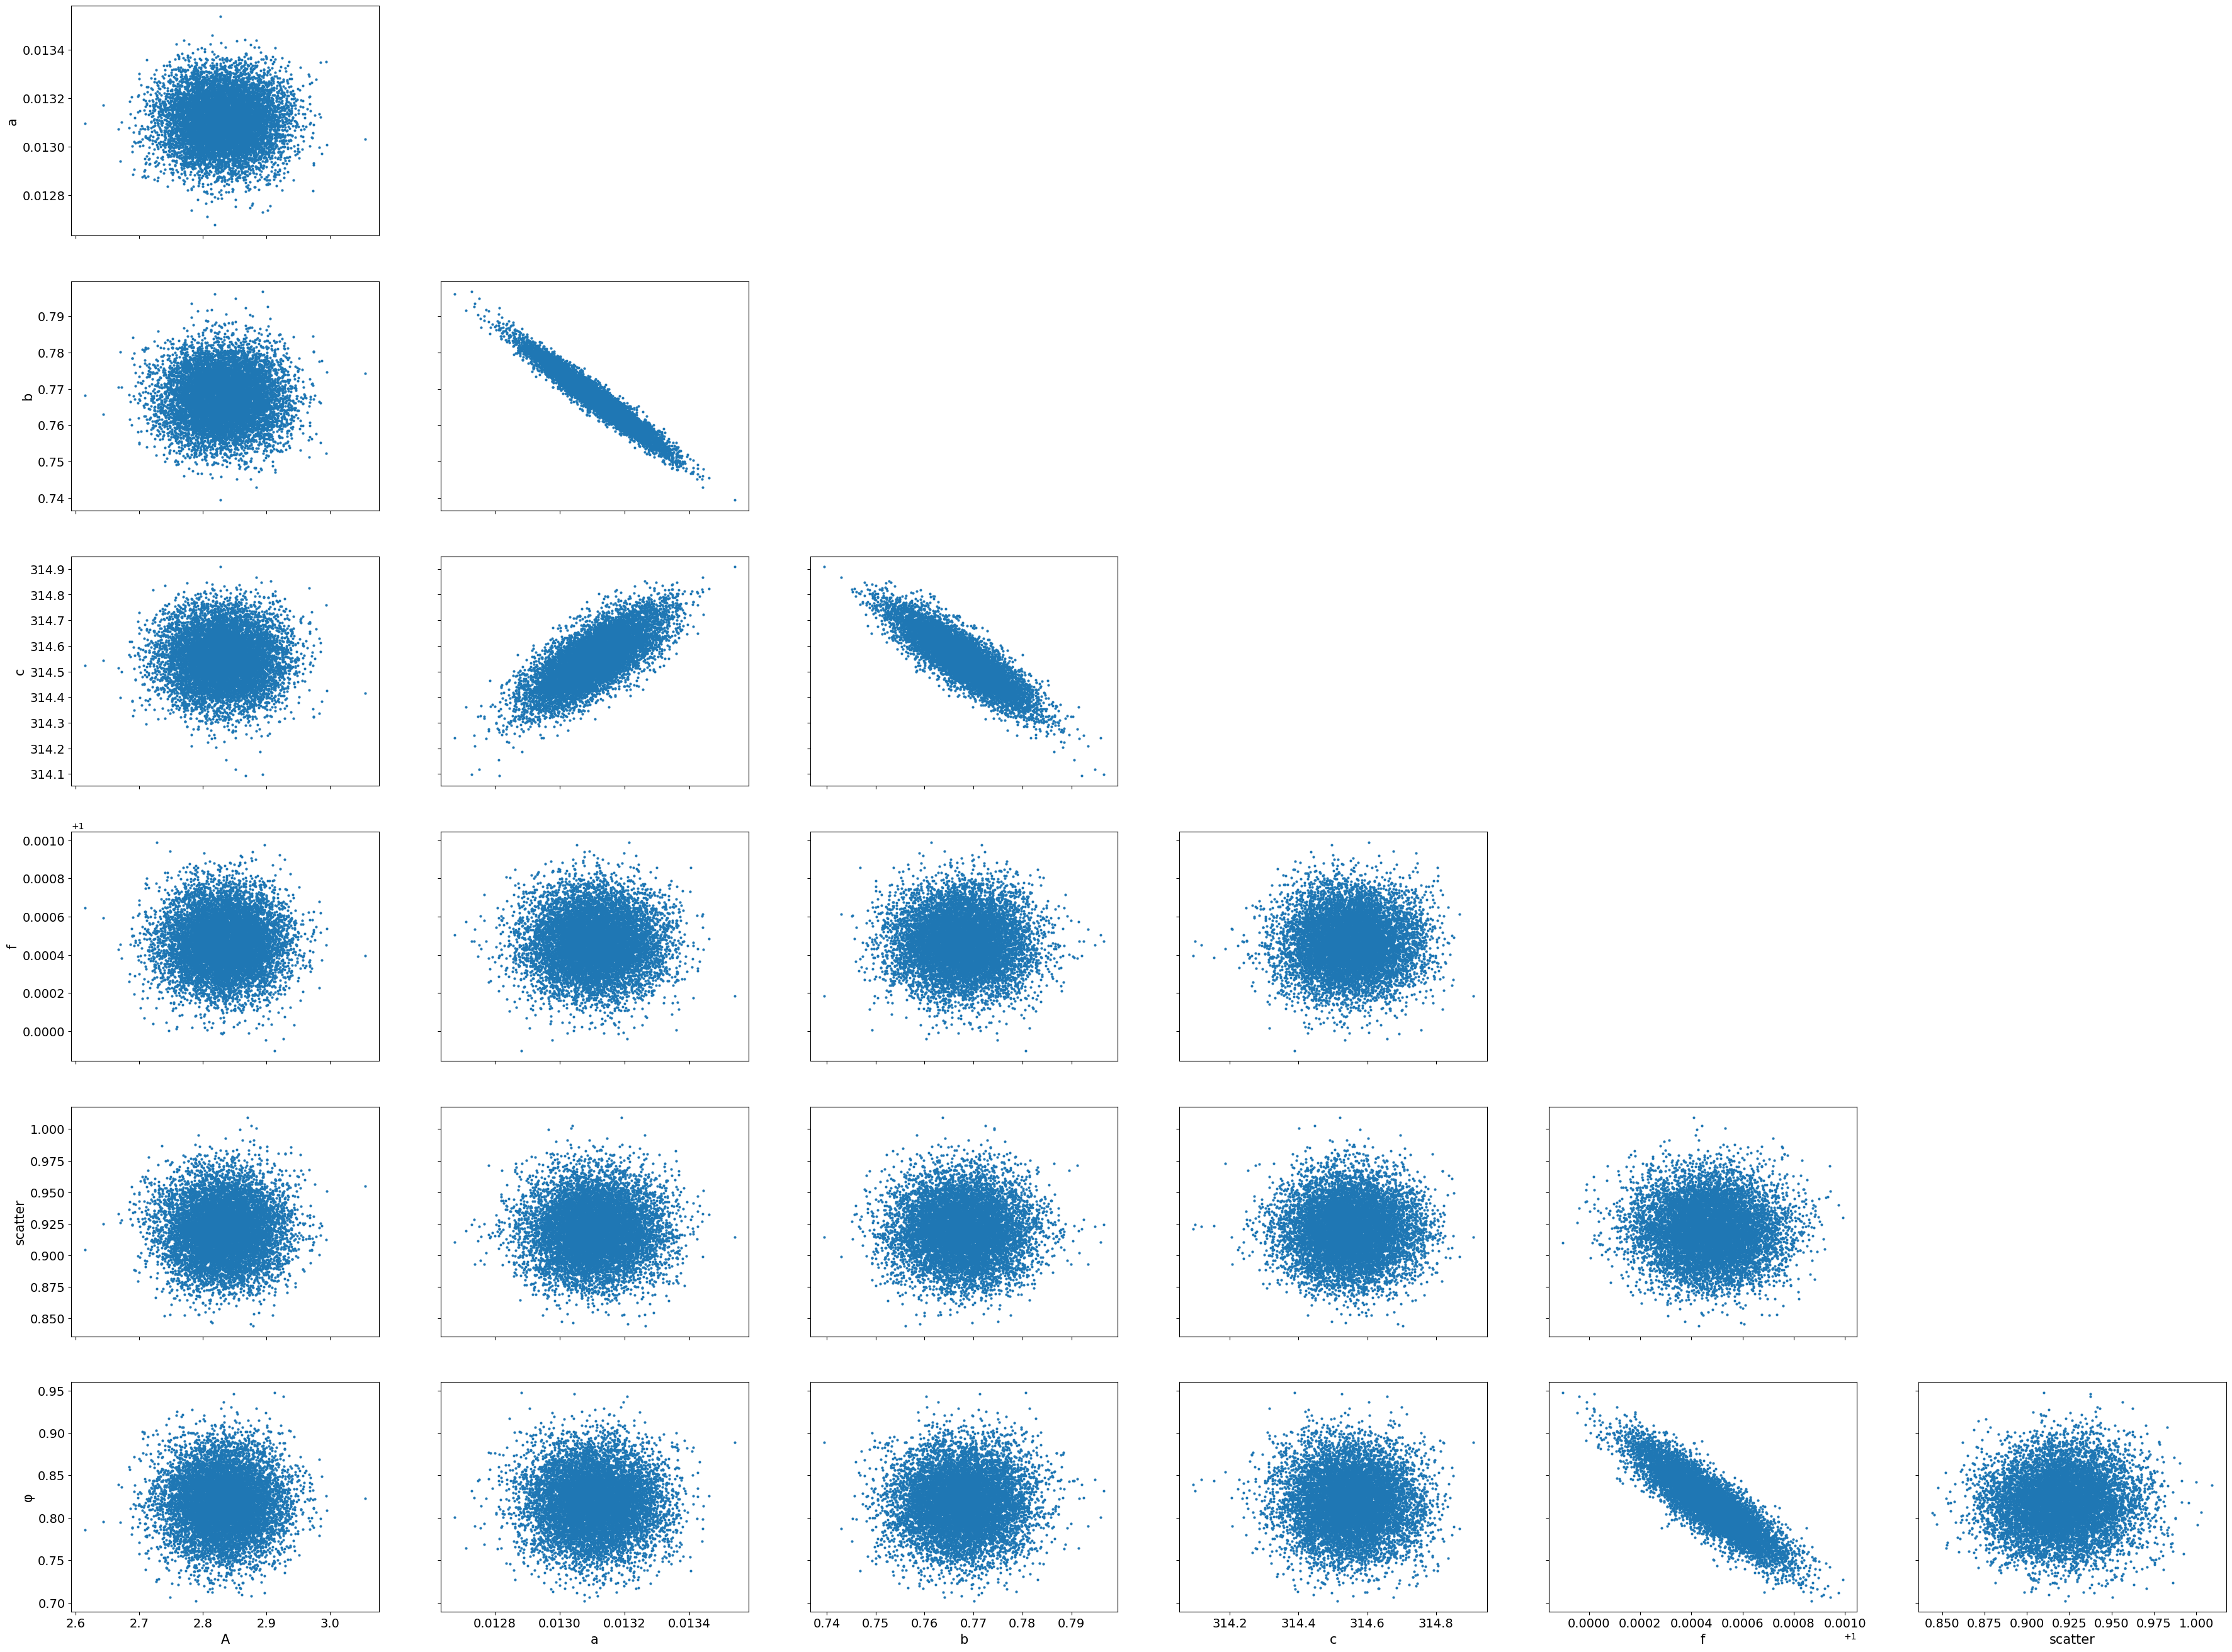

In [34]:
az.plot_pair(mcmc, var_names=['~μ']);

We see some strong correlations between quadratic coefficients, and between amplitude and phase.  It doesn't look like there are strong correlations between parameters fitting the quadratic and periodic components, so our results may not differ so much from the sequential fit we did.  Regardless, we wouldn't have known that unless we did the Right Thing and modeled the data self-consistently.

In [35]:
samples = mcmc.get_samples()

Now let's check the fidelity of our model.

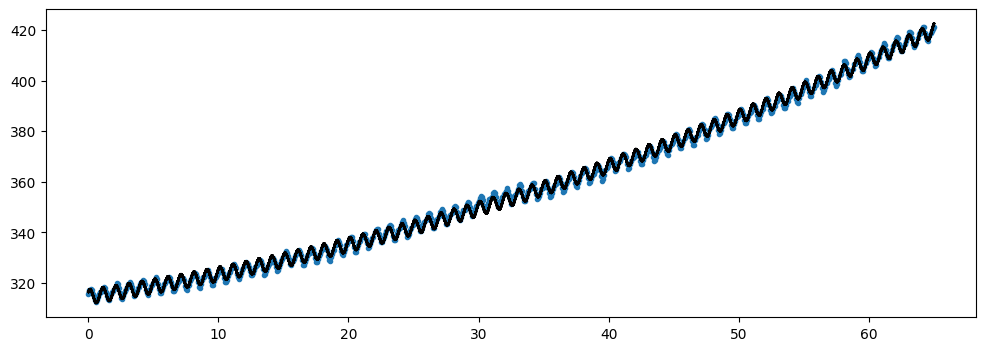

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(date, co2, marker='.')

for i in random.choice(rng_key, len(samples['μ']), shape=(100,)):
    plt.plot(date, samples['μ'][i], color='k', alpha=0.5)
# plt.xlim(date.min(), date.min()+10)  # uncomment to zoom in on first 10 years
# plt.ylim(top=330);

Not too shabby!  Now let's see if we can do something more useful with our model, and use it to extrapolate.  Let's predict what observations may look like for the next decade.  We can use the posterior predictive framework to do this by plugging in times in the future.  We'll also include the last decade to get a sense of how well our model predicts the most recent observations for comparison.

In [37]:
dt = jnp.diff(date)[-1]
tgrid = jnp.arange(date.max()-10, date.max()+10, dt)

post_pred_samples = infer.Predictive(quad_seasonal_model, samples)(
    random.PRNGKey(1), time=tgrid,
)
post_pred_y = post_pred_samples["co2"]
post_pred_y.shape

(10000, 241)

I'm just going to draw a single example to visualize a single series of possible observations, but you can turn this up if you want to see many possible sets of observations according to our model.

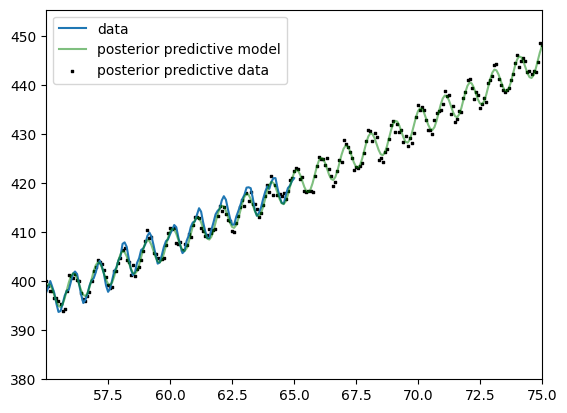

In [38]:
plt.plot(date, co2, label='data');
line_label = 'posterior predictive model'
scatter_label = 'posterior predictive data'
for i in random.choice(rng_key, len(post_pred_y), (1,)):
    plt.plot(tgrid, post_pred_samples['μ'][i], color='green', alpha=0.5, label=line_label)
    plt.scatter(tgrid, post_pred_y[i], color='k', marker=',', s=1, alpha=1, label=scatter_label)
    line_label = scatter_label = None
plt.legend()
plt.xlim(date.max()-10, date.max()+10)
plt.ylim(bottom=380);

As a bonus, let's redo our analysis and _exclude_ data from the last decade, then use posterior predictive checks again the actual observations to see how are model did.

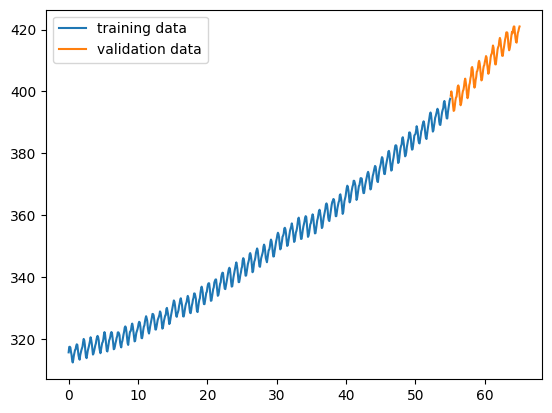

In [39]:
last_decade_sel = date > date.max()-10
plt.plot(date[~last_decade_sel], co2[~last_decade_sel], label='training data')
plt.plot(date[last_decade_sel], co2[last_decade_sel], label='validation data')
plt.legend();

In [40]:
kernel = infer.NUTS(
    quad_seasonal_model,
    init_strategy=infer.init_to_value(values={'A':2.8, 'f': 1.0, 'scatter':0.9, 'φ':0.9}),
)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=2000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         time=date[~last_decade_sel],
         co2=co2[~last_decade_sel])
mcmc.print_summary()

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      2.80      0.05      2.80      2.72      2.88   6251.13      1.00
         a      0.01      0.00      0.01      0.01      0.01   4283.41      1.00
         b      0.82      0.01      0.82      0.81      0.83   3806.08      1.00
         c    314.14      0.10    314.14    313.98    314.31   3709.02      1.00
         f      1.00      0.00      1.00      1.00      1.00   5934.87      1.00
   scatter      0.87      0.02      0.87      0.84      0.91   6228.61      1.00
         φ      0.81      0.04      0.81      0.75      0.87   5463.69      1.00

Number of divergences: 0


In [41]:
samples = mcmc.get_samples()

Now let's draw mock date for all of our observations (as opposed to a sparse grid in time).

In [42]:
post_pred_samples = infer.Predictive(quad_seasonal_model, samples)(
    random.PRNGKey(1), time=date,
)
post_pred_y = post_pred_samples["co2"]
post_pred_y.shape

(10000, 781)

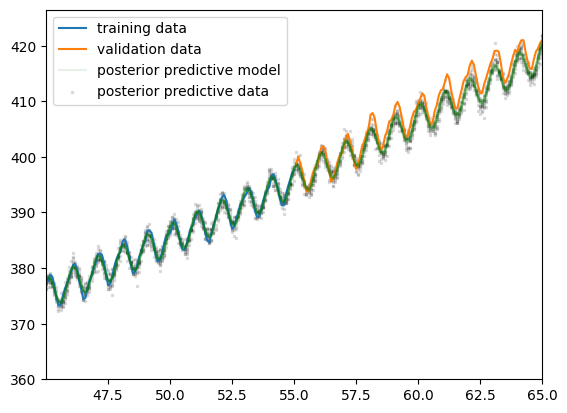

In [43]:
plt.plot(date[~last_decade_sel], co2[~last_decade_sel], label='training data')
plt.plot(date[last_decade_sel], co2[last_decade_sel], label='validation data')

line_label = 'posterior predictive model'
scatter_label = 'posterior predictive data'
for i in random.choice(rng_key, len(post_pred_y), (10,)):
    plt.plot(date, post_pred_samples['μ'][i], color='green', alpha=0.1, label=line_label)
    plt.scatter(date, post_pred_y[i], color='k', marker=',', s=1, alpha=0.1, label=scatter_label)
    line_label = scatter_label = None
    plt.legend()
    plt.xlim(date.max()-20, date.max())
    plt.ylim(bottom=360);

Ok, so our predicted trend (green) and data (black) _do_ follow the general trend of the data we excluded from the inference (orange), but our model seems to systematically underpredict the CO<sub>2</sub> concentrations, and the underprediction gets worse the further we extrapolate (this is generally true of most extrapolation; the further you go, the harder it gets).

Ultimately we do surprisingly well with a rather simplistic model of the data, but there is still room for improvement.  We may return to this problem in the future with more sophisticated models, if time and interest is sufficient.